In [1]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import seaborn as sns
%matplotlib inline
%run dataset.ipynb

def select_gene_nonzeroratio(df, ratio):
    nonzerocounts = np.count_nonzero(df.values, axis=0) / df.shape[0]
    selected_genes = df.columns[nonzerocounts > ratio]
    return selected_genes

In [2]:
datasetname = 'onemillionv2'
dataset = DATASET(datasetname)
dataset.load_dataset()
data_sc = dataset.data_sc

In [3]:
monocyte_ut = data_sc[(data_sc.obs['time']=='UT') & (data_sc.obs['cell_type_lowerres']=='monocyte')]
monocyte_ut_df = pd.DataFrame(data=monocyte_ut.X.toarray(),
                              index=monocyte_ut.obs.index,
                              columns=monocyte_ut.var.index)
mono_genes = select_gene_nonzeroratio(df=monocyte_ut_df, ratio=0.50)
print(len(mono_genes))

395


In [6]:
bp_df = pd.read_csv('mono_gene_nor_combat_20151109.ProbesWithZeroVarianceRemoved.ProbesCentered.SamplesZTransformed.1PCAsOverSamplesRemoved.txt.gz',
                   compression='gzip',
                   sep='\t', index_col=0)
name_mapping_dic = pd.read_csv('features_v3_reformated_names.tsv',
                          sep ='\t',
                          names=['geneid', 'genename']).set_index(['geneid'])['genename'].T.to_dict()

bp_df['geneid'] = [item.split('.')[0] for item in bp_df.index]
bp_df['genename'] = [name_mapping_dic.get(geneid) for geneid in bp_df['geneid']]
bp_df = bp_df.dropna(subset=['genename'])
bp_df = bp_df.drop('geneid', axis=1)
bp_df = bp_df.set_index('genename')
print(bp_df.shape)

bp_trans_df = bp_df.T
common_genes = list(set(mono_genes) & set(bp_trans_df.columns))
selected_mono_df = monocyte_ut_df[common_genes]
selected_bp_df = bp_trans_df[common_genes]
print(selected_mono_df.shape, selected_bp_df.shape)

(11482, 379) (194, 379)


In [7]:
selected_mono_df.T.to_csv('sc_Expression.csv', sep=',')
selected_bp_df.T.to_csv('bp_Expression.csv', sep=',')

In [8]:
# create this fake pseudo time ordering because it's required to run the Beeline tool, but not used by GRNBoost2
fake_timepoint_bp = pd.DataFrame(index=selected_bp_df.index)
fake_timepoint_bp['time'] = np.arange(selected_bp_df.shape[0])
fake_timepoint_bp.to_csv('bp_timepoint.fake.csv',
                        sep=',')
fake_timepoint_sc = pd.DataFrame(index=selected_mono_df.index)
fake_timepoint_sc['time'] = np.arange(selected_mono_df.shape[0])
fake_timepoint_sc.to_csv('sc_timepoint.fake.csv',
                        sep=',')

In [9]:
# perform GRNBoost2 with BEELINE, see the yaml files in the same directory
# python BLRunner.py --config config-files/config_bp_mono.yaml
# python BLRunner.py --config config-files/config_sc_mono.yaml

In [10]:
sc_edges = pd.read_csv('sc_edges.csv', sep='\t')
sc_edges['sorted_genepairs'] = [';'.join(item) for item in sc_edges[['Gene1', 'Gene2']].values]
bp_edges = pd.read_csv('bp_edges.csv', sep='\t')
bp_edges['sorted_genepairs'] = [';'.join(item) for item in bp_edges[['Gene1', 'Gene2']].values]

sc_edges = sc_edges.set_index('sorted_genepairs')
bp_edges = bp_edges.set_index('sorted_genepairs')
concated_edges = pd.concat([sc_edges.add_suffix('_sc'), bp_edges.add_suffix('_bp')], axis=1)

concated_edges.head()

,Gene1_sc,Gene2_sc,EdgeWeight_sc,Gene1_bp,Gene2_bp,EdgeWeight_bp
sorted_genepairs,,,,,,
CCL3;CCL4,CCL3,CCL4,554.503642,CCL3,CCL4,55.157748
CCL4;CCL3,CCL4,CCL3,480.484753,CCL4,CCL3,77.414467
S100A9;S100A8,S100A9,S100A8,341.726427,S100A9,S100A8,104.542395
S100A8;S100A9,S100A8,S100A9,284.321568,S100A8,S100A9,65.915233
S100A9;LYZ,S100A9,LYZ,221.872616,S100A9,LYZ,0.149064


In [11]:
concated_edges = concated_edges.dropna()
spearmanr(concated_edges['EdgeWeight_sc'], concated_edges['EdgeWeight_bp'])

SpearmanrResult(correlation=0.16937964029402044, pvalue=0.0)

Text(0.5, 1.0, 'Spearman r = 0.17')

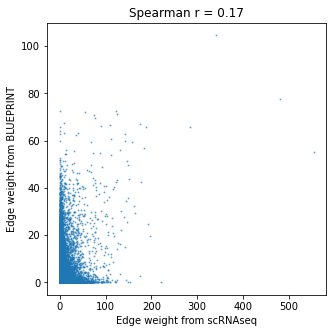

In [12]:
coef, p = spearmanr(concated_edges['EdgeWeight_sc'], concated_edges['EdgeWeight_bp'])
plt.figure(figsize=(5, 5))
plt.scatter(concated_edges['EdgeWeight_sc'], concated_edges['EdgeWeight_bp'], s=1, alpha=0.5)
plt.xlabel('Edge weight from scRNAseq')
plt.ylabel('Edge weight from BLUEPRINT')
plt.title(f'Spearman r = {coef:.2f}')
# plt.savefig('grnboost2_sc_bp_comparison.png')